# U-Net++

In [8]:
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join('../..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [10]:
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
from torchvision import transforms
from models import METAINFO, NUM_CLASSES

# Parameters
IMG_SIZE = 512
BATCH_SIZE = 8
NUM_EPOCHS = 10

# 1. Architecture

## 1.1. Loss function

In [ ]:
# the loss function has been modified to remove dice weight because the results are not optimal
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

## 1.2. Layers

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.conv(x)

## 1.3. Model

In [12]:
class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, deep_supervision=True, dropout_prob=0.1):
        super(UNetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = ConvBlock(3, nb_filter[0], dropout_prob)
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1], dropout_prob)
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2], dropout_prob)
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3], dropout_prob)
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4], dropout_prob)

        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1], dropout_prob)
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2], dropout_prob)
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3], dropout_prob)

        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], dropout_prob)
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], dropout_prob)

        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], dropout_prob)
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], dropout_prob)

        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], dropout_prob)

        # intermediate results can be returned if needed
        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            return output

# 2. Dataset

In [13]:
# a helper function to 
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

train_df = load_and_sample_data('../../dataset/train_sample_30.csv')
val_df = load_and_sample_data('../../dataset/val_sample_30.csv')
test_df = load_and_sample_data('../../dataset/test.csv')

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

class WildScene(Dataset):
    def __init__(self, df, img_size, num_classes, is_train=False):
        self.df = df
        self.img_size = img_size
        self.num_classes = num_classes
        self.is_train = is_train

        # Training transforms with data augmentation
        self.train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
        ])

        # Evaluation transforms without data augmentation
        self.eval_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread('../../' + row['im_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread('../../' + row['label_path'], cv2.IMREAD_GRAYSCALE)

        if self.is_train:
            # Apply training transforms
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            img = self.train_transform(img)
            
            torch.manual_seed(seed)
            label = transforms.functional.to_tensor(
                transforms.functional.resize(
                    transforms.ToPILImage()(label), 
                    (self.img_size, self.img_size)
                )
            )
        else:
            # Apply evaluation transforms
            img = self.eval_transform(img)
            label = transforms.functional.to_tensor(
                transforms.functional.resize(
                    transforms.ToPILImage()(label), 
                    (self.img_size, self.img_size)
                )
            )

        label = label.squeeze().long()

        return img, label

# Create datasets and dataloaders, it is always a good idea to use data loader because we can apply data augmentation
train_dataset = WildScene(train_df, IMG_SIZE, NUM_CLASSES)
val_dataset = WildScene(val_df, IMG_SIZE, NUM_CLASSES)
test_dataset = WildScene(test_df, IMG_SIZE, NUM_CLASSES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # shuffle is enabled to make batch random
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 3. Training

In [14]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                if isinstance(outputs, list):
                    loss = sum([criterion(output, labels) for output in outputs]) / len(outputs)
                else:
                    loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, labels = images.cuda(), labels.cuda()
                with autocast():
                    outputs = model(images)
                    if isinstance(outputs, list):
                        loss = sum([criterion(output, labels) for output in outputs]) / len(outputs)
                    else:
                        loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training complete.")
    return model, train_losses, val_losses

## Training Results

In [6]:
model = UNetPlusPlus(num_classes=NUM_CLASSES, deep_supervision=True).cuda()
optimizer = optim.Adam(model.parameters())
criterion = FocalLoss(alpha=0.5, gamma=1, reduction='mean')

trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=NUM_EPOCHS)

Validation Epoch 1/10: 100%|██████████| 65/65 [01:26<00:00,  1.32s/it]


Epoch 1/10, Train Loss: 0.4939, Val Loss: 0.2327


Validation Epoch 2/10: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 2/10, Train Loss: 0.2463, Val Loss: 0.2725


Validation Epoch 3/10: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 3/10, Train Loss: 0.2259, Val Loss: 0.2096


Validation Epoch 4/10: 100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


Epoch 4/10, Train Loss: 0.2111, Val Loss: 0.2001


Validation Epoch 5/10: 100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


Epoch 5/10, Train Loss: 0.2019, Val Loss: 0.2078


Validation Epoch 6/10: 100%|██████████| 65/65 [01:05<00:00,  1.00s/it]


Epoch 6/10, Train Loss: 0.1961, Val Loss: 0.2037


Validation Epoch 7/10: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 7/10, Train Loss: 0.1934, Val Loss: 0.1754


Validation Epoch 8/10: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 8/10, Train Loss: 0.1892, Val Loss: 0.1947


Validation Epoch 9/10: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 9/10, Train Loss: 0.1849, Val Loss: 0.1824


Validation Epoch 10/10: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]

Epoch 10/10, Train Loss: 0.1836, Val Loss: 0.1785
Training complete.


## Loss Plot

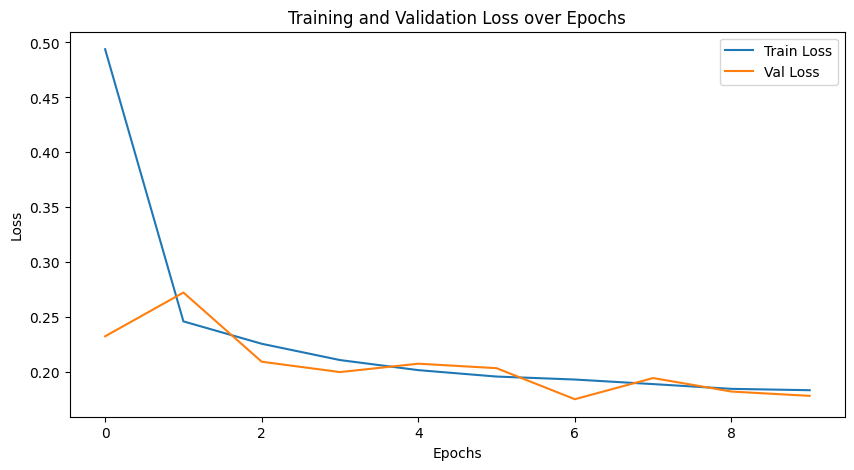

In [7]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

# 4. Testing

In [8]:
def test_and_evaluate_model(model, test_loader, criterion, classes, palette):
    model.eval()
    total_loss = 0
    class_ious = {cls: 0 for cls in classes}
    merged_classes = []
    merged_ious = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            
            if isinstance(outputs, list):
                outputs = outputs[-1]

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            # Calculate IoU
            preds = torch.argmax(outputs, dim=1)
            for pred, label in zip(preds, labels):
                pred = pred.cpu().numpy().flatten()
                label = label.cpu().numpy().flatten()
                for class_idx in np.unique(label):
                    if class_idx in np.unique(pred):
                        iou = calculate_class_iou(label, pred, len(classes))[class_idx]
                        class_ious[classes[class_idx]] += iou

        # Merge classes as required
        for class_name in classes:
            if class_name == "pole":
                other_object_idx = classes.index("other-object")
                class_ious[classes[other_object_idx]] += class_ious[class_name]
            elif class_name == "asphalt/concrete":
                other_terrain_idx = classes.index("other-terrain")
                class_ious[classes[other_terrain_idx]] += class_ious[class_name]
            elif class_name not in ["vehicle", "pole", "asphalt/concrete", "unlabelled"]:
                merged_classes.append(class_name)
                merged_ious.append(class_ious[class_name])

        merged_class_ious = dict(zip(merged_classes, merged_ious))

    # Calculate test loss
    test_loss = total_loss / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    # Print IoU results
    print("\nClass-wise IoU:")
    total_iou = 0
    for class_name, iou in sorted(merged_class_ious.items()):
        total_iou += iou / len(test_loader.dataset) * 100
        print(f"Class {class_name:<20} IoU: {iou / len(test_loader.dataset) * 100:.4f}")

    # Calculate Mean IoU
    mean_iou = total_iou / len(merged_classes)
    print(f"\nMean IoU: {mean_iou:.4f}")

    # Prediction on a sample image
    sample_image, sample_label = next(iter(test_loader))
    sample_image, sample_label = sample_image.cuda(), sample_label.cuda()
    prediction = predict(model, sample_image)

    # Visualize sample image, ground truth, and prediction
    visualize_prediction(sample_image, sample_label, prediction, palette)

    return test_loss, merged_class_ious

def calculate_class_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_class = (y_true == cls)
        pred_class = (y_pred == cls)

        intersection = (true_class & pred_class).sum().item()
        union = (true_class | pred_class).sum().item()

        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union

        ious.append(iou)

    return ious

def predict(model, image):
    with torch.no_grad():
        outputs = model(image)
        if isinstance(outputs, list):
            return outputs[-1]  # Use the final output for prediction
        return outputs


In [9]:
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

def visualize_prediction(image, label, prediction, palette):
    image = image[0].cpu().numpy().transpose((1, 2, 0))
    label = label[0].cpu().numpy()
    prediction = prediction[0].argmax(dim=0).cpu().numpy()

    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(label_to_rgb(label, palette))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(label_to_rgb(prediction, palette))
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

In [10]:
def calculate_class_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_class = (y_true == cls)
        pred_class = (y_pred == cls)

        intersection = (true_class & pred_class).sum().item()
        union = (true_class | pred_class).sum().item()

        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union

        ious.append(iou)

    return ious

# Define function to evaluate the model
def evaluate_model(model, test_loader, classes):
    model.eval()
    class_ious = {cls: 0 for cls in classes}
    merged_classes = []
    merged_ious = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            
            # If model outputs a list, take the last element
            if isinstance(outputs, list):
                outputs = outputs[-1]
                
            preds = torch.argmax(outputs, dim=1)

            for pred, label in zip(preds, labels):
                pred = pred.cpu().numpy().flatten()
                label = label.cpu().numpy().flatten()

                for class_idx in np.unique(label):
                    if class_idx in np.unique(pred):
                        iou = calculate_class_iou(label, pred, len(classes))[class_idx]
                        class_ious[classes[class_idx]] += iou

    for class_name in classes:
        if class_name == "pole":
            other_object_idx = classes.index("other-object")
            class_ious[classes[other_object_idx]] += class_ious[class_name]
        elif class_name == "asphalt/concrete":
            other_terrain_idx = classes.index("other-terrain")
            class_ious[classes[other_terrain_idx]] += class_ious[class_name]
        elif class_name not in ["vehicle", "pole", "asphalt/concrete", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(class_ious[class_name])

    merged_class_ious = dict(zip(merged_classes, merged_ious))
    return merged_class_ious

# Evaluate the model
classes = METAINFO['classes']
merged_class_ious = evaluate_model(trained_model, test_loader, classes)

# Print IoU results
print("\nClass-wise IoU:")
total_iou = 0
for class_name, iou in sorted(merged_class_ious.items()):
    total_iou += iou / len(test_loader.dataset) * 100
    print(f"Class {class_name:<20} IoU: {iou / len(test_loader.dataset) * 100:.4f}")

# Calculate Mean IoU
mean_iou = total_iou / 15
print(f"\nMean IoU: {mean_iou:.4f}")

# Save the trained model
torch.save(trained_model.state_dict(), 'unetpp_best.pth')
print("Model saved as 'unetpp_best.pth'")

Testing: 100%|██████████| 267/267 [11:54<00:00,  2.68s/it]


Class-wise IoU:
Class bush/shrub           IoU: 0.0198
Class dirt                 IoU: 55.6213
Class fence                IoU: 0.0000
Class grass                IoU: 47.5001
Class gravel               IoU: 0.0016
Class log                  IoU: 0.0036
Class mud                  IoU: 0.0000
Class other-object         IoU: 0.1765
Class other-structure      IoU: 0.3251
Class other-terrain        IoU: 0.0000
Class rock                 IoU: 0.0000
Class sky                  IoU: 53.8352
Class tree-foliage         IoU: 82.6171
Class tree-trunk           IoU: 47.5705
Class water                IoU: 0.0000

Mean IoU: 19.1781
Model saved as 'unetplusplus_best_model.pth'
